In [28]:
import os
import cv2
import numpy as np
import librosa
import tensorflow as tf
import librosa.display
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, LSTM, MaxPooling2D, AveragePooling2D, Dropout, TimeDistributed, Reshape
from tensorflow.keras.utils import to_categorical
from sklearn.neural_network import MLPClassifier

# **Loading The Data In wave form**

In [2]:
def load_audio_file(file_path, duration=2.0, sr=22050):
    audio_data, sr = librosa.load(file_path, sr=sr, duration=duration, mono=True)
    return audio_data, sr

In [3]:
def load_data_from_folders(real_folder, fake_folder, sr=22050):
    real_data = []
    fake_data = []
    labels = []

    # Load real data
    for file_name in os.listdir(real_folder):
        if file_name.endswith('.wav'):
            audio_data, _ = load_audio_file(os.path.join(real_folder, file_name), sr=sr)
            real_data.append(audio_data)
            labels.append(1)  # Label 1 for real voices

    # Load fake data
    for file_name in os.listdir(fake_folder):
        if file_name.endswith('.wav'):
            audio_data, _ = load_audio_file(os.path.join(fake_folder, file_name), sr=sr)
            fake_data.append(audio_data)
            labels.append(0)  # Label 0 for fake voices

    return real_data, fake_data, labels


In [4]:
real_data, fake_data, labels = load_data_from_folders('/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/real', '/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/fake')

**Visualizing the data in  wave form**

In [5]:
def visualize_waveform(audio_data, sr, title):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio_data, sr=sr)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()


In [6]:
def visualize_audio_from_folders(real_folder, fake_folder):
    # Load and visualize real data
    real_files = os.listdir(real_folder)[:2]
    for file_name in real_files:
        if file_name.endswith('.wav'):
            audio_data, sr = load_audio_file(os.path.join(real_folder, file_name))
            visualize_waveform(audio_data, sr, title=f'Real: {file_name}')
    
    # Load and visualize fake data
    fake_files = os.listdir(fake_folder)[:2]
    for file_name in fake_files:
        if file_name.endswith('.wav'):
            audio_data, sr = load_audio_file(os.path.join(fake_folder, file_name))
            visualize_waveform(audio_data, sr, title=f'Fake: {file_name}')


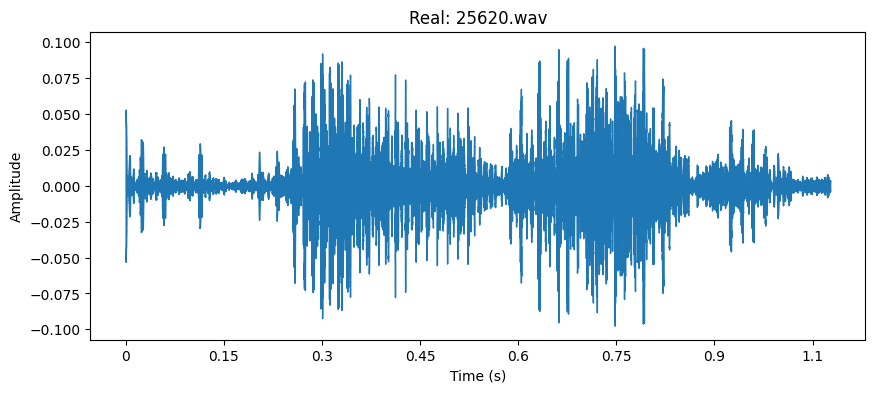

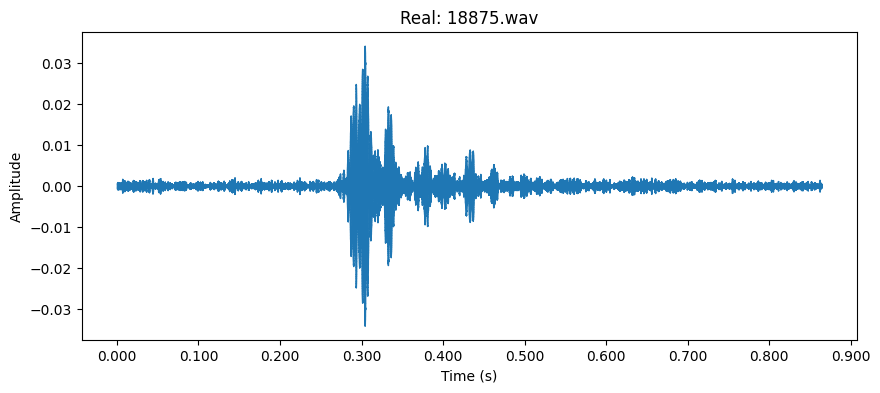

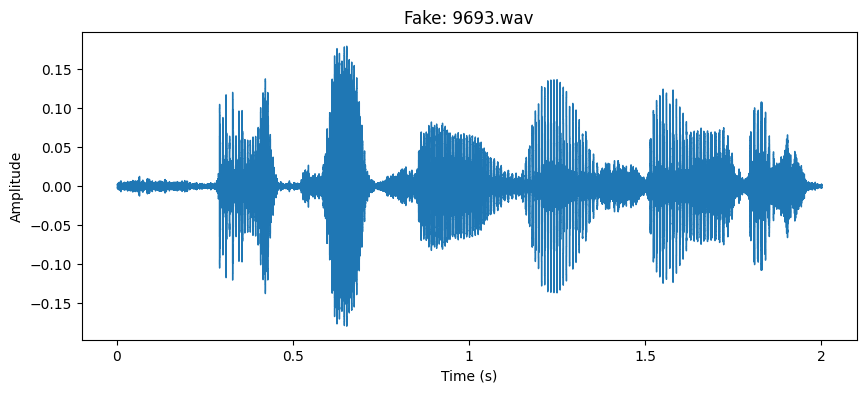

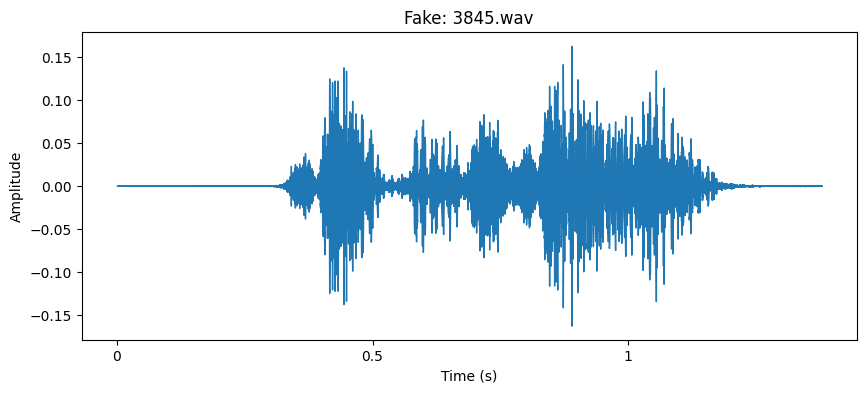

In [7]:

visualize_audio_from_folders('/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/real', '/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/fake')


In [8]:
def extract_spectrogram(audio_data, sr):
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr)
    return spectrogram

In [9]:
def extract_spectrograms(data, sr):
    spectrograms = []
    for audio in data:
        spectrogram = extract_spectrogram(audio, sr)
        spectrograms.append(spectrogram)
    return spectrograms

In [10]:
sr = 22050
real_spectrograms = extract_spectrograms(real_data, sr)
fake_spectrograms = extract_spectrograms(fake_data, sr)

**Visualization of Spectrogams**

In [11]:
def visualize_spectrogram(spectrogram, sr):
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

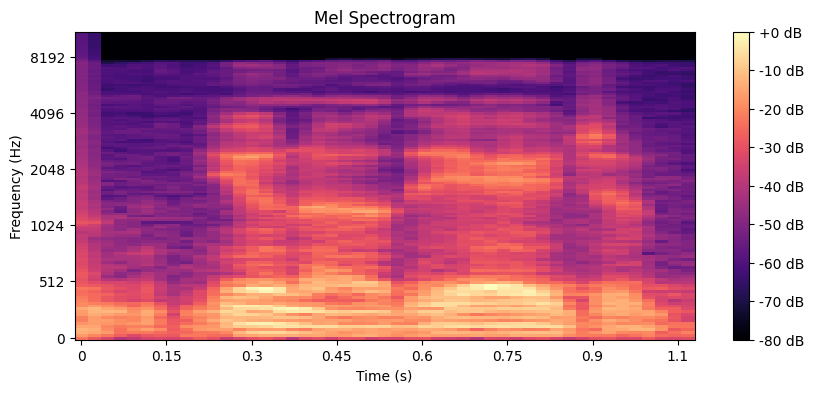

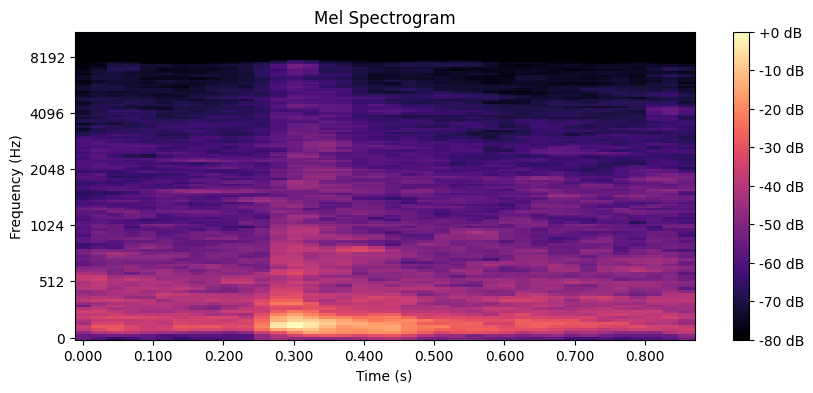

In [12]:
# Visualize first two real spectrograms
for spectrogram in real_spectrograms[:2]:
    visualize_spectrogram(spectrogram, sr)

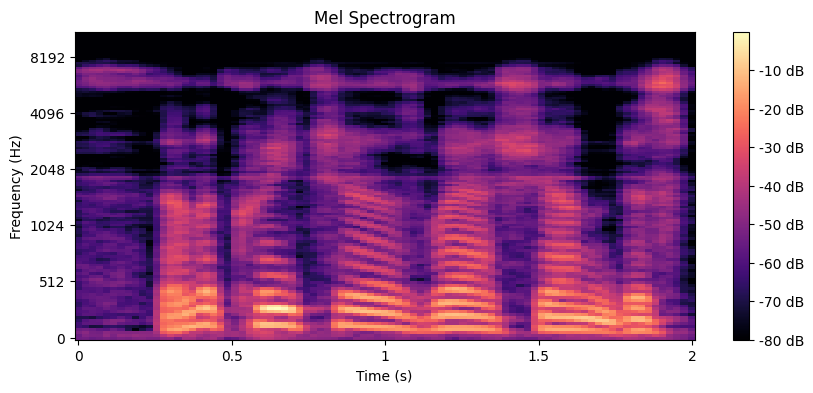

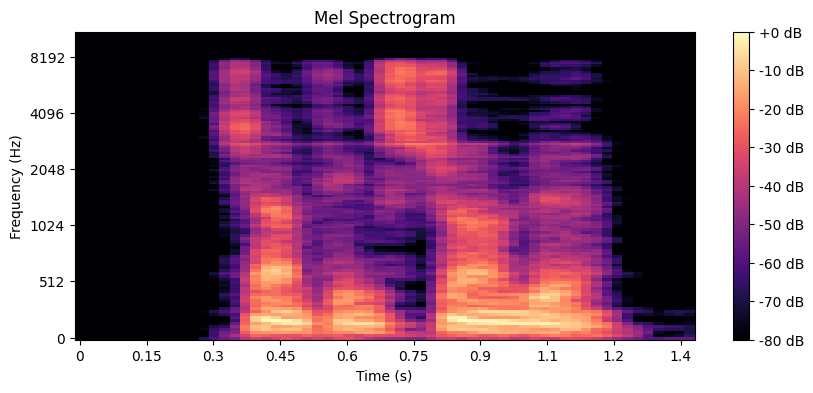

In [13]:
# Visualize first two fake spectrograms
for spectrogram in fake_spectrograms[:2]:
    visualize_spectrogram(spectrogram, sr)

# **Extracting Features**

In [14]:
def extract_features(spectrogram):
    log_mel_spectrogram = librosa.power_to_db(spectrogram)
    mfccs = librosa.feature.mfcc(S=log_mel_spectrogram, n_mfcc=13)
    return np.mean(mfccs.T, axis=0)

In [15]:
# Extract features from spectrograms
real_features = [extract_features(spectrogram) for spectrogram in real_spectrograms]
fake_features = [extract_features(spectrogram) for spectrogram in fake_spectrograms]

In [16]:
labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [17]:
real_features

[array([-382.8115   ,  160.98326  ,  -23.09495  ,   63.905506 ,
           3.2671425,   28.92823  ,  -18.000881 ,    9.576202 ,
         -18.33184  ,   -4.937886 ,  -11.596073 ,   -4.664502 ,
           1.5247793], dtype=float32),
 array([-6.1767120e+02,  1.3456750e+02,  3.7112451e+00,  3.5345028e+01,
         6.2342000e+00,  1.1987012e+01, -3.8663013e+00, -5.1213324e-01,
        -5.5108124e-01,  1.2016764e+00, -3.1402865e-01, -5.6979618e+00,
        -6.0080462e+00], dtype=float32),
 array([-346.16742  ,   92.039215 ,  -46.81317  ,   47.21077  ,
           5.544027 ,   28.487698 ,  -24.65626  ,    6.5835347,
          -7.314517 ,   -9.680003 ,  -13.192241 ,  -14.204832 ,
          -2.561918 ], dtype=float32),
 array([-384.61502  ,  171.19138  ,  -49.51895  ,   17.39527  ,
          14.949394 ,  -11.274962 ,   -2.360893 ,  -10.04061  ,
          -2.6427276,   -3.8591323,   -9.41827  ,   -3.1721117,
          -3.4689279], dtype=float32),
 array([-376.411    ,  123.94881  ,  -17.937365 , 

In [18]:
X = np.concatenate((real_features, fake_features), axis=0)
y = np.array([1]*len(real_features) + [0]*len(fake_features))

In [19]:
X_resized = np.array([cv2.resize(x, (128, 128)) for x in X])

In [21]:
X_resized = np.expand_dims(X_resized, axis=-1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=38, stratify=y)

# **Building a Model Architecture**

In [31]:
# Build the hybrid CNN-RNN model
model = Sequential()

# Convolutional blocks
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(AveragePooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D((2, 2)))
model.add(Dropout(0.2))

# Flatten for dense layers
model.add(Flatten())

# Dense blocks
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 63, 63, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 30, 30, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 14, 14, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,515,713 (24.86 MB)

 Trainable params: 6,515,713 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
636/636 ━━━━━━━━━━━━━━━━━━━━ 305s 480ms/step - accuracy: 0.9541 - loss: 0.1150 - val_accuracy: 0.9420 - val_loss: 0.1470
Epoch 2/25
636/636 ━━━━━━━━━━━━━━━━━━━━ 306s 481ms/step - accuracy: 0.9564 - loss: 0.1127 - val_accuracy: 0.9485 - val_loss: 0.1428
Epoch 3/25
636/636 ━━━━━━━━━━━━━━━━━━━━ 305s 480ms/step - accuracy: 0.9570 - loss: 0.1154 - val_accuracy: 0.9465 - val_loss: 0.1418
Epoch 4/25
636/636 ━━━━━━━━━━━━━━━━━━━━ 300s 472ms/step - accuracy: 0.9564 - loss: 0.1086 - val_accuracy: 0.9481 - val_loss: 0.1398
Epoch 5/25
636/636 ━━━━━━━━━━━━━━━━━━━━ 331s 486ms/step - accuracy: 0.9638 - loss: 0.0986 - val_accuracy: 0.9473 - val_loss: 0.1360
Epoch 6/25
636/636 ━━━━━━━━━━━━━━━━━━━━ 321s 505ms/step - accuracy: 0.9609 - loss: 0.1048 - val_accuracy: 0.9457 - val_loss: 0.1510
Epoch 7/25
636/636 ━━━━━━━━━━━━━━━━━━━━ 309s 486ms/step - accuracy: 0.9605 - loss: 0.1039 - val_accuracy: 0.9461 - val_loss: 0.1609
Epoch 8/25
636/636 ━━━━━━━━━━━━━━━━━━━━ 310s 488ms/step - accuracy: 0.9606 -

In [38]:
loss, accuracy = model.evaluate(X_test, y_test)

199/199 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.9525 - loss: 0.1705


In [39]:
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.95


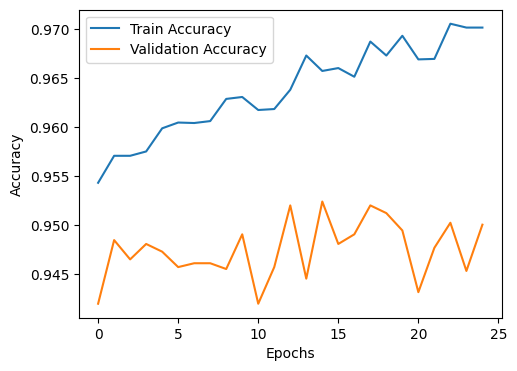

In [40]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

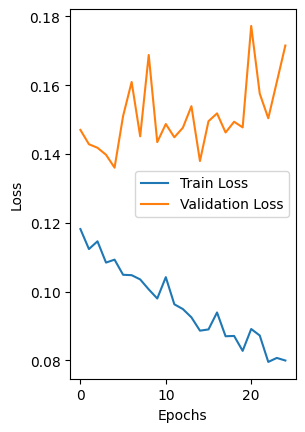

In [41]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Please do tell me how can I imporve my model. I have used Hybrid approach because it helped with other audio classification task. Tell me better approach to do it. Thankyou in advance.**